In [1]:
!pip install catboost
!pip install eli5
!pip install hyperopt

     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 106 kB 22.9 MB/s 


In [3]:
!pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error

import holidays
import calendar
import datetime
from datetime import datetime, timedelta #timedelta umozliwi dodanie 1 dnia

from sklearn.model_selection import GroupKFold

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
# from scikitplot.estimators import plot_learning_curve
import eli5
%matplotlib inline

In [4]:

df_train = pd.read_hdf("/content/energy_train.h5")
df_test = pd.read_hdf("/content/energy_test.h5")

df_train.head(1)

,id,date,value
24,24,2018-03-02,20842.538


In [5]:
df_train.shape, df_test.shape #((26517, 3), (8735, 2))
df_train.isnull().any() #brak nulli

df=pd.concat([df_train,df_test])
df.shape #(35252, 3)
df['date']=pd.to_datetime(df['date'])

In [6]:
#   #  df['day_']=df[['date_year', 'date_dayofyear']].apply(lambda x: x['date_dayofyear']+int(str(x['date_year'])[-1])*365, axis=1)
# # int(str(df['date_year'])[-1])*365
# df['date'].dt.date.isin(holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022])).astype(int)
# # holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022])
# df['date'].dt.daysinmonth
# pd.to_datetime(df['date']).dt.normalize()
# # df['date'].dt.date.isin(holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022]))
# df['date_month'].map(lambda x: (x%12 + 3)//3)

ex = {k: v for k, v in sorted(holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022]).items()) if v =='Nowy Rok'}
pd.to_datetime(list(ex.keys()))

DatetimeIndex(['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',
               '2022-01-01'],
              dtype='datetime64[ns]', freq=None)

In [18]:

    

def feature_engineering(df):
    
    df['date_year']=df['date'].dt.year
    df['date_diff_year']=df['date_year']-2018  #2018:0;...2022:4
    df['date_month']=df['date'].dt.month
    df['date_day']=df['date'].dt.day
    df['date_hour']=df['date'].dt.hour
    df['date_dayofweek']=df['date'].dt.dayofweek #Monday=0, Sunday=6
    df['date_dayofyear']=df['date'].dt.dayofyear   
    df['date_week']=df['date'].dt.week
    df['date_weekend']=df['date_dayofweek'].map(lambda x: int(x in[5,6])) #weekend  1 true ;0 False
    df['day_']=df[['date_year', 'date_dayofyear']].apply(lambda x: x['date_dayofyear']+int(str(x['date_year'])[-1])*365, axis=1)
    df['rush_hour'] = df['date_hour'].map(lambda x: 0 if (x < 7 or x> 22) else 1) #0 noc/dzien 1  #.map(lambda x: 1 if ((x >=6) & (x<13)) | ((x >=15) & (x<22)) else 0 )
    df['holidays'] =df['date'].dt.date.isin(holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022])).astype(int)  #1 swieto   False/true.astype(int)
    df['peak']= df[['rush_hour', 'date_weekend', 'holidays']].apply(lambda x: 1 if (x['rush_hour']==1)& (x['date_weekend']==0) & (x['holidays']==0) else 0, axis=1) #dzien,nie weekend,nie swieto
    df['workingday']=df[['date_weekend', 'holidays']].apply(lambda x: 1 if ((x['date_weekend']==0) & (x['holidays']==0)) else 0, axis=1) #nie weekend,nie swieto

    df['wakacje'] = df['date_month'].map(lambda x: 1 if (x == 7) | (x == 8) else 0)
    df['trend'] = df['date_year'].map(lambda x: 1 if (x==2018) | (x==2019) else 2 if (x==2020) else 3)

    day_before_holidays_pl = []
    for date in holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022]).items():
      day_before_holidays_pl.append(str(date[0] - timedelta(days = 1 )))
    df['day_before_holidays'] = df['date'].apply(lambda x: 1 if str(x) in day_before_holidays_pl else 0)

    day_after_holidays_pl = []
    for date in holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022]).items():
      day_after_holidays_pl.append(str(date[0] + timedelta(days = 1 )))
    df['day_after_holidays_pl'] = df['date'].apply(lambda x: 1 if str(x) in day_after_holidays_pl else 0)


    df['hour_2'] = df['date_hour'].isin([2])
    df['hour_0'] = df['date_hour'].isin([0])
    df['hour_1'] = df['date_hour'].isin([1])
    df['hour_3'] = df['date_hour'].isin([3])
    df['hour_4'] = df['date_hour'].isin([4])
    df['hour_5'] = df['date_hour'].isin([5])
    df['hour_6'] = df['date_hour'].isin([6])
    df['hour_7'] = df['date_hour'].isin([7])
    df['hour_8'] = df['date_hour'].isin([8])
    df['hour_9'] = df['date_hour'].isin([9])
    df['hour_10'] = df['date_hour'].isin([10])
    df['hour_11'] = df['date_hour'].isin([11])
    df['hour_12'] = df['date_hour'].isin([12])
    df['hour_13'] = df['date_hour'].isin([13])
    df['hour_14'] = df['date_hour'].isin([14])
    df['hour_15'] = df['date_hour'].isin([15])
    df['hour_16'] = df['date_hour'].isin([16])
    df['hour_17'] = df['date_hour'].isin([17])
    df['hour_18'] = df['date_hour'].isin([18])
    df['hour_19'] = df['date_hour'].isin([19])
    df['hour_20'] = df['date_hour'].isin([20])
    df['hour_21'] = df['date_hour'].isin([21])
    df['hour_22'] = df['date_hour'].isin([22])
    df['hour_23'] = df['date_hour'].isin([23])

    df['boze_cialo'] = df['date'].isin(['2018-05-20','2019-06-09','2020-06-11', '2021-06-03'])
    df['boze_nar'] = df['date'].isin(['2018-12-25','2018-12-26','2019-12-25','2019-12-26','2020-12-25','2020-12-26','2021-12-25','2021-12-26'])     
    df['majowka'] = df['date'].isin(['2018-05-01', '2018-05-02','2018-05-03',  '2019-05-01','2019-05-02', 
                                      '2019-05-03', '2020-05-01','2020-05-02', '2020-05-03', '2021-05-01','2021-05-02', '2021-05-03', '2022-05-01','2022-05-02', '2022-05-03'])
    df['wigilia'] = df['date'].isin(['2018-12-24','2019-12-24','2020-12-24','2021-12-24','2022-12-24'])
    df['szesciu_kroli'] = df['date'].isin(['2018-01-06','2019-01-06','2020-01-06','2021-01-06','2022-01-06'])
    df['wielkanoc'] = df['date'].isin(['2018-04-01','2018-04-02',
                                        '2019-04-21','2019-04-22','2020-04-13','2020-04-12',
                                        '2021-04-04','2022-04-05'])
    df['W_swietych'] = df['date'].isin(['2018-11-01','2019-11-01','2020-11-01','2021-11-01'])
    df['11_listopada'] = df['date'].isin(['2018-11-11','2019-11-11','2020-11-11','2021-11-11'])
    df['wielka_sobota'] = df['date'].isin(['2018-03-31','2019-04-20','2020-04-11','2021-04-03'])

    df['luty_15_2021'] = df.apply(lambda x: 1 if (x['date_day']==15) & (x['date_month']==2) else 0, axis = 1) #Międzynarodowy Dzień Oszczędzania Energii
    

    df['day_of_month']=df['date'].dt.daysinmonth #The number of days in the month. #del
    df['day_month_ratio']=df['day_of_month']/df['date_day']
    df['date_norm']=pd.to_datetime(df['date']).dt.normalize() #date-time is converted to midnight  00:00:00 / YYYY-MM-DD bez godzin 
    df['date_day_ratio']=df.apply(lambda x: x['date_dayofyear']/366  if (x['date_year']==2020) else x['date_dayofyear']/365, axis=1) ##rok przystepny uwzglednic
    df['date_week_ratio']=df['date_dayofweek'].map(lambda x: (x+1)/7)

    df['czas_zimowy'] = df['date'].map(lambda x: 1 if ((x>=pd.to_datetime('2021-10-31').date()) & 
                                                        (x<pd.to_datetime('2022-03-27').date())) | 
    ((x>=pd.to_datetime('2020-10-25').date()) & (x<pd.to_datetime('2021-03-28').date())) | 
    ((x>=pd.to_datetime('2019-10-27').date()) & (x<pd.to_datetime('2020-03-29').date())) | 
    ((x>=pd.to_datetime('2018-10-28').date()) & (x<pd.to_datetime('2019-03-30').date()))
    else 0)
    df['zmiana_letnia'] = df['date'].isin(['2019-03-30','2020-03-29','2021-03-28','2022-03-27']).astype(int)

    # df['season_2'] = df['date_month'].map(lambda x: (x%12 + 3)//3) #Month 12,1-2:1, 3-5:2, 6-8:3, 9-11:4
    def get_season(x):
        if (x['date_month'] in [1,2,3]): return 1
        if (x['date_month'] in [4,5,6]): return 2 
        if (x['date_month'] in [7,8,9]): return 3 
        if (x['date_month'] in [10,11,12]): return 4  
        return x['date_month']
    df['season']=df.apply(get_season, axis=1)
    
    
#    df_train = df[ df.value.notnull() ]
    
    d5 = df.groupby( ["date_hour", 'date_month'] ).agg([np.median, np.mean])['value'].reset_index()
    d5.rename(columns={'median': 'median_df_q5','mean': 'mean_df_q5'}, inplace=True)
    df = pd.merge(df, d5, on=["date_hour", 'date_month'], how = 'left')
   
    df['is_month_start']=df['date'].dt.is_month_start  #True dla 01.XX
    df['date_quarter']=df['date'].dt.quarter
    df['is_month_endt']=df['date'].dt.is_month_end #T dla 31.xx
    df['is_quarter_start']=df['date'].dt.is_quarter_start   
    df['is_quarter_end']=df['date'].dt.is_quarter_end   
    df['is_year_start']=df['date'].dt.is_year_start   #true dla 01-01.YYYY
    df['is_year_end']=df['date'].dt.is_year_end   
    df['is_leap_year']=df['date'].dt.is_leap_year  # which has 366 days (instead of 365) including 29th of February as an intercalary day 

    obj_bool=df.select_dtypes(bool).columns
    for cat_feat in obj_bool:
        df['{0}_cat'.format(cat_feat)]=pd.factorize(df[cat_feat])[0].astype(np.int8) #pd.factorize(string)[0]  -> liczba  / pd.factorize(string)[1] -> uniques/distinct val
        del df[cat_feat]
    
    return df  
  

In [44]:
# from datetime import datetime, timedelta
# #wyliczam dzien przed swietami
# day_before_holidays_pl = []
# for date in holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022]).items():
#   day_before_holidays_pl.append(str(date[0] - timedelta(days = 1 )))
# df['day_before_holidays'] = df['date_norm'].apply(lambda x: 1 if str(x) in day_before_holidays_pl else 0)

# #wyliczam 1 dzien po swietach
# day_after_holidays_pl = []
# for date in holidays.CountryHoliday('PL',years=[2018,2019,2020,2021,2022]).items():
#   day_after_holidays_pl.append(str(date[0] + timedelta(days = 1 )))
# df['day_after_holidays_pl'] = df['date_norm'].apply(lambda x: 1 if str(x) in day_after_holidays_pl else 0)



#df['pelny_lockdown'] = df.date_norm.map(lambda x: 1 if (x>=pd.to_datetime('2020-03-24').date()) & 
#                                                        (x<pd.to_datetime('2020-04-12').date()) else 0)
     
#df['zamkniecie_szkol'] = df.date_norm.map(lambda x: 1 if (x>=pd.to_datetime('2020-03-12').date()) & 
#                                                        (x<pd.to_datetime('2020-05-24').date()) else 0 )
#df['zamkniecie_szkol_2'] = df.date_norm.map(lambda x: 1 if (x>=pd.to_datetime('2020-10-23').date()) & 
#                                                        (x<pd.to_datetime('2020-11-09').date()) else 0 )


# df['value_shift_24'] =  df['value'].shift(24)
# df['value_shift_168'] =  df['value'].shift(168)
# df['coalesce_shift'] = df.apply(lambda x: x['value_shift_168']  if (x['date_dayofweek'] == 0) | (x['date_dayofweek'] == 5) else x['value_shift_24'] , axis=1)
# df['value_shift_24'].rolling(336).mean()

In [7]:
df.head()

,id,date,value
24,24,2018-03-02 00:00:00,20842.538
25,25,2018-03-02 01:00:00,20108.125
26,26,2018-03-02 02:00:00,19480.463
27,27,2018-03-02 03:00:00,19235.275
28,28,2018-03-02 04:00:00,19149.388


In [43]:
pd.set_option('display.max_columns', None)
df_all = feature_engineering(df)
df_all.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


,id,date,value,date_year,date_diff_year,date_month,date_day,date_hour,date_dayofweek,date_dayofyear,date_week,date_weekend,day_,rush_hour,holidays,peak,workingday,wakacje,trend,day_before_holidays,day_after_holidays_pl,luty_15_2021,day_of_month,day_month_ratio,date_norm,date_day_ratio,date_week_ratio,czas_zimowy,zmiana_letnia,season,median_df_q5,mean_df_q5,date_quarter,hour_2_cat,hour_0_cat,hour_1_cat,hour_3_cat,hour_4_cat,hour_5_cat,hour_6_cat,hour_7_cat,hour_8_cat,hour_9_cat,hour_10_cat,hour_11_cat,hour_12_cat,hour_13_cat,hour_14_cat,hour_15_cat,hour_16_cat,hour_17_cat,hour_18_cat,hour_19_cat,hour_20_cat,hour_21_cat,hour_22_cat,hour_23_cat,boze_cialo_cat,boze_nar_cat,majowka_cat,wigilia_cat,szesciu_kroli_cat,wielkanoc_cat,W_swietych_cat,11_listopada_cat,wielka_sobota_cat,is_month_start_cat,is_month_endt_cat,is_quarter_start_cat,is_quarter_end_cat,is_year_start_cat,is_year_end_cat,is_leap_year_cat
5103,6854,2018-12-11 15:00:00,24807.238,2018,0,12,11,15,1,345,50,0,3265,1,0,1,1,0,1,0,0,0,31,2.818182,2018-12-11,0.945205,0.285714,1,0,4,23672.8750,22568.972021,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23412,31067,2021-09-15 15:00:00,21910.313,2021,3,9,15,15,2,258,37,0,623,1,0,1,1,0,3,0,0,0,30,2.000000,2021-09-15,0.706849,0.428571,0,0,3,21204.1250,20181.990621,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19975,26598,2021-03-13 09:00:00,20040.388,2021,3,3,13,9,5,72,10,1,437,1,0,0,0,0,3,0,0,0,31,2.384615,2021-03-13,0.197260,0.857143,1,0,1,22649.1565,21472.905142,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32282,22659,2020-09-30 06:00:00,NaN,2020,2,9,30,6,2,274,40,0,274,0,0,0,1,0,2,0,0,0,30,1.000000,2020-09-30,0.748634,0.428571,0,0,3,15925.1130,15793.105724,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
9294,12533,2019-08-05 07:00:00,16386.450,2019,1,8,5,7,0,217,32,0,3502,1,0,1,1,1,1,0,0,0,31,6.200000,2019-08-05,0.594521,0.142857,0,0,3,16951.4690,16376.684289,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


    date_hour  date_dayofweek         value
0           0               0  18123.110209
1           0               1  18421.931177
2           0               2  18303.958401
3           0               3  18312.222006
4           0               4  18175.289791
5           0               5  16346.374070
6           0               6  16022.130890
7           1               0  15150.726646
8           1               1  17185.764443
9           1               2  17289.813611
10          1               3  17298.927570
11          1               4  17265.621690
12          1               5  17068.694899
13          1               6  15319.309854
14          2               0  14725.446430


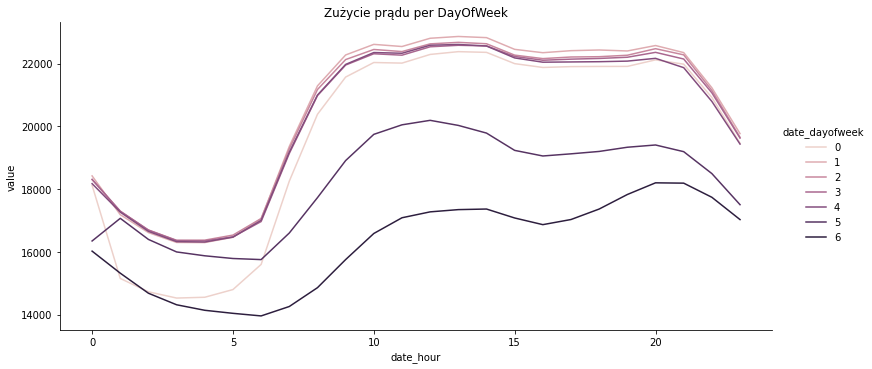

In [17]:
_ = df_all\
    .groupby(['date_hour', 'date_dayofweek'], as_index=False)\
    .agg({'value':'mean'})
print(_.head(15))
sns.relplot(x="date_hour", y="value", hue='date_dayofweek', kind="line", data=_, aspect=2.2);
plt.title('Zużycie prądu per DayOfWeek' );

In [82]:
# df[['holidays', 'day_before_holidays', 'day_after_holidays_pl']].apply(lambda x: 2 if (str(x['holidays'])==1) else 1 if (x['day_before_holidays']==1) else 3 if (x['day_after_holidays_pl']==1) else 0)
df.sample(1)

,id,date,value,date_year,date_diff_year,date_month,date_day,date_hour,date_dayofweek,date_dayofyear,date_week,date_weekend,day_,rush_hour,holidays,peak,workingday,day_of_month,day_month_ratio,date_norm,date_day_ratio,date_week_ratio,season,date_quarter,is_month_start_cat,is_month_endt_cat,is_quarter_start_cat,is_quarter_end_cat,is_year_start_cat,is_year_end_cat,is_leap_year_cat,day_before_holidays,day_after_holidays_pl
18766,18766,2020-04-21 01:00:00,NaN,2020,2,4,21,1,1,112,17,0,112,0,0,0,1,30,1.428571,2020-04-21,0.306011,0.285714,2,2,0,0,0,0,0,0,1,0,0


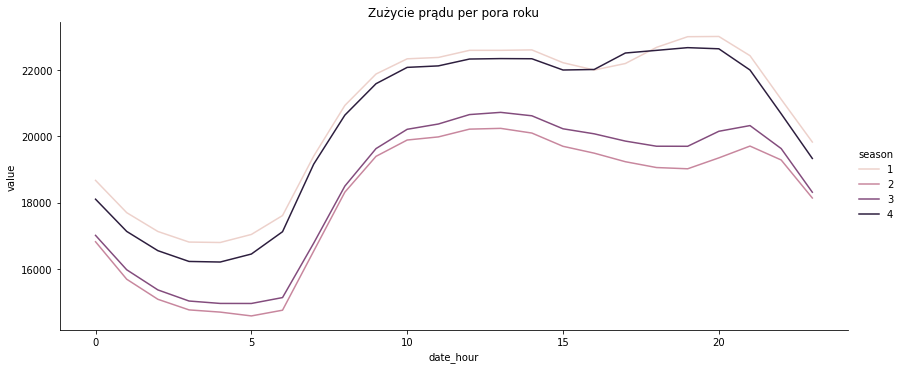

In [85]:
# df[['season']] zima,wiosna> lato,jesien
_ = df\
    .groupby(['date_hour', 'season'], as_index=False)\
    .agg({'value':'mean'})
sns.relplot(x="date_hour", y="value", hue='season', kind="line", data=_, aspect=2.4); #
plt.title('Zużycie prądu per pora roku');



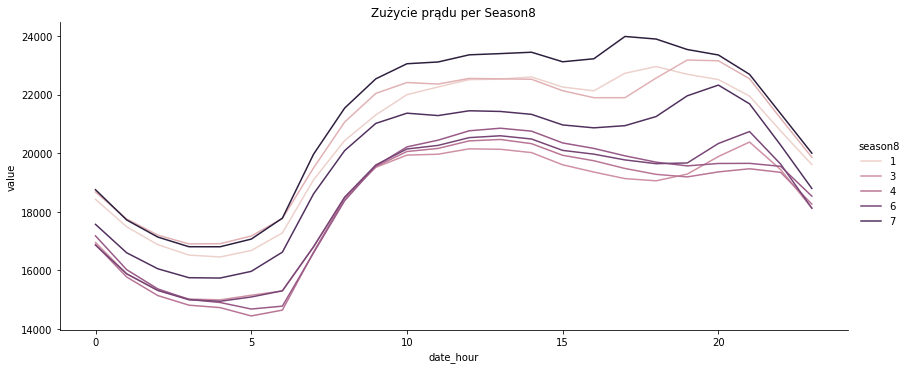

In [93]:
#podzial na 8 sezonów wzgledem pór roku. Pora roku dodatkowo podzielona na pół
df['season8'] = df['date_dayofyear'].apply(lambda x: 
                              1 if x<36 else 
                              2 if x<81 else
                              3 if x<128 else
                              4 if x<174 else
                              5 if x<221 else
                              6 if x<267 else
                              7 if x<312 else
                              8 if x<357 else 1
                             )
_ = df\
    .groupby(['date_hour', 'season8'], as_index=False)\
    .agg({'value':'mean'})
sns.relplot(x="date_hour", y="value", hue='season8', kind="line", data=_, aspect=2.4); #

plt.title('Zużycie prądu per Season8');

In [ ]:
# plt.figure(figsize=(15,7))
# sns.lineplot(x="month_", y="value", hue="year_", data=train_prep)
# plt.title('Zuzycie prądu per Year');

In [25]:
train_prep = df[df["value"].notnull()] 
train_prep['pct_change'] = train_prep['value'].pct_change().mul(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


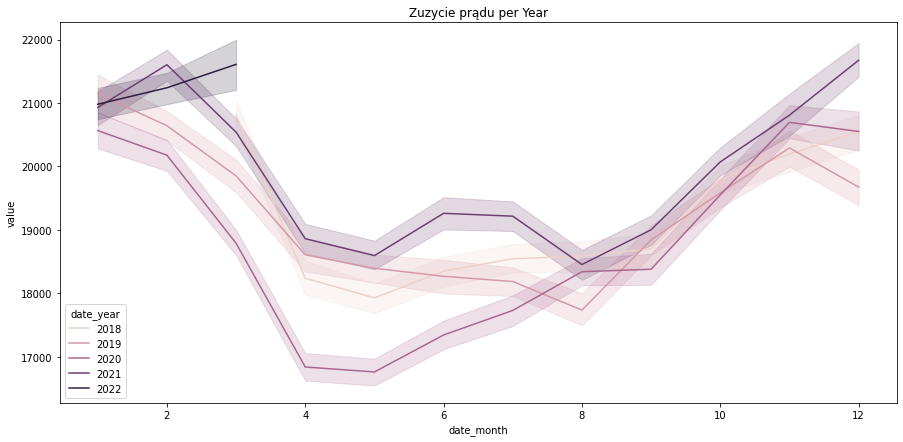

In [33]:
plt.figure(figsize=(15,7))
sns.lineplot(x="date_month", y="value", hue="date_year", data=train_prep)
plt.title('Zuzycie prądu per Year');

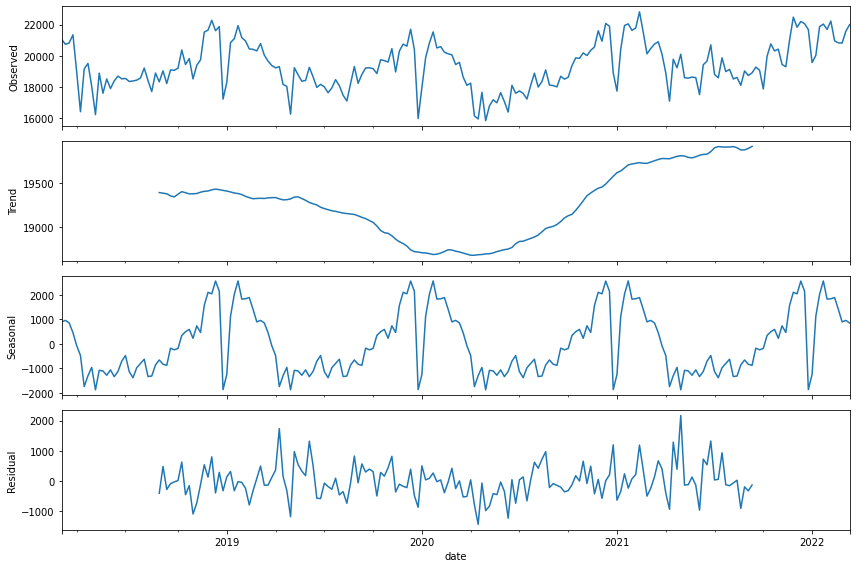

In [40]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8


df_all = pd.concat([df_train, df_test])
df_all["date"] = pd.to_datetime(df_all["date"])

df_all = df_all.set_index('date')
df_all.sort_index(inplace=True)

df_0_1m = df_all.resample('1W').mean()
decomposition = sm.tsa.seasonal_decompose(df_0_1m.value, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

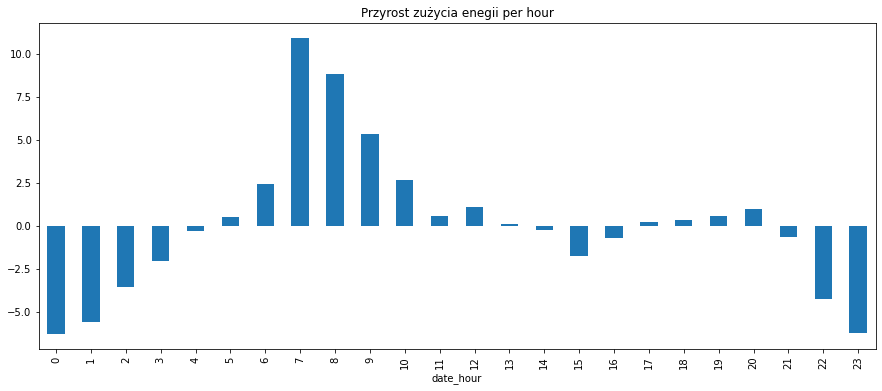

In [46]:
plt.figure(figsize=(15,6))
#train_prep['pct_change'] = train_prep['value'].pct_change().mul(100)
train_prep.groupby(['date_hour']).agg(np.mean)['pct_change'].plot(kind='bar')
plt.title('Przyrost zużycia enegii per hour');

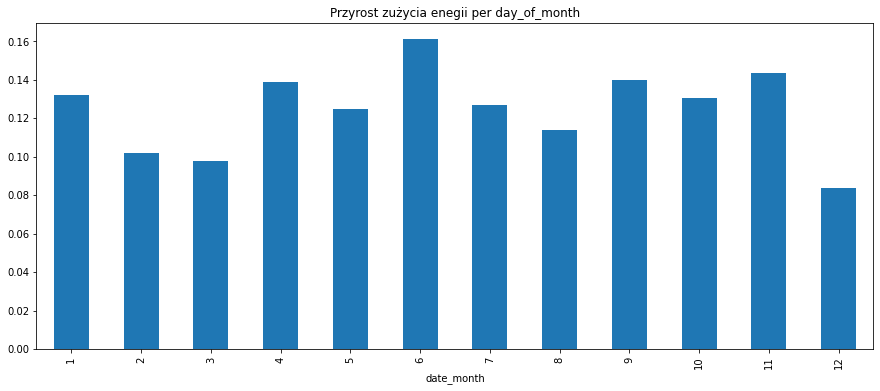

In [52]:
plt.figure(figsize=(15,6))
train_prep.groupby(['date_month']).agg(np.mean)['pct_change'].plot(kind='bar')
plt.title('Przyrost zużycia enegii per day_of_month');

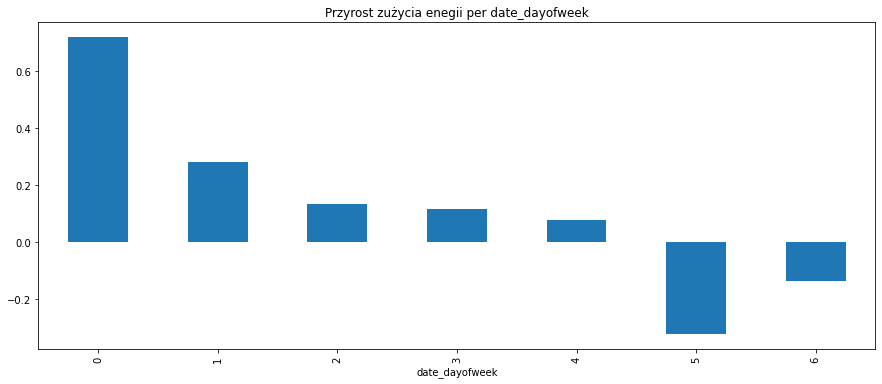

In [54]:
plt.figure(figsize=(15,6))
train_prep.groupby(['date_dayofweek']).agg(np.mean)['pct_change'].plot(kind='bar')
plt.title('Przyrost zużycia enegii per date_dayofweek');

25740.534


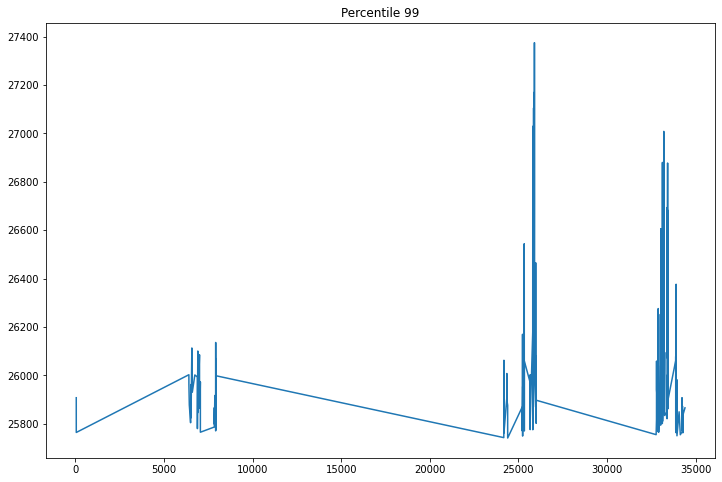

In [59]:
perc99 = np.percentile(train_prep.value, 99)
print( perc99 )
train_prep[ train_prep.value >= perc99]['value'].plot()
plt.title('Percentile 99');

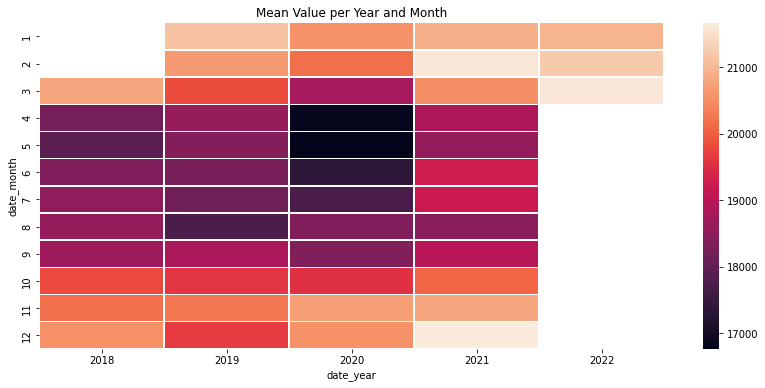

In [61]:
plt.figure(figsize=(14,6))
sns.heatmap(train_prep.groupby(['date_month', 'date_year']).aggregate('value').mean().reset_index().pivot('date_month', 'date_year', 'value'), linewidths=.5)
plt.title('Mean Value per Year and Month');

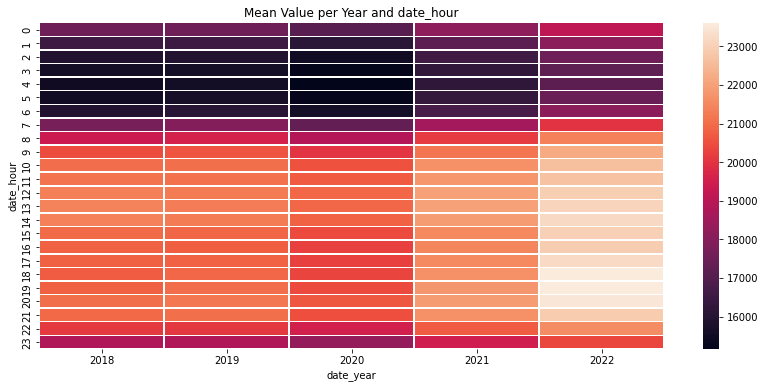

In [66]:
plt.figure(figsize=(14,6))
sns.heatmap(train_prep.groupby(['date_hour', 'date_year']).aggregate('value').mean().reset_index().pivot('date_hour', 'date_year', 'value'), linewidths=.5)
plt.title('Mean Value per Year and date_hour');

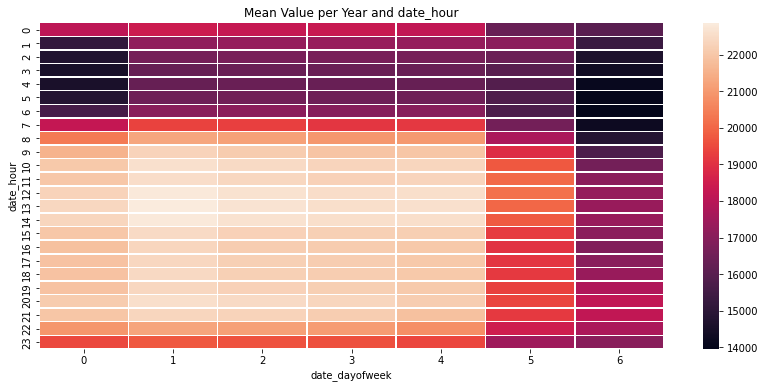

In [67]:
plt.figure(figsize=(14,6))
sns.heatmap(train_prep.groupby(['date_hour', 'date_dayofweek']).aggregate('value').mean().reset_index().pivot('date_hour', 'date_dayofweek', 'value'), linewidths=.5)
plt.title('Mean Value per Year and date_hour');

In [50]:
df_all

,id,date,value,date_year,date_diff_year,date_month,date_day,date_hour,date_dayofweek,date_dayofyear,date_week,date_weekend,day_,rush_hour,holidays,peak,workingday,wakacje,trend,day_before_holidays,day_after_holidays_pl,luty_15_2021,day_of_month,day_month_ratio,date_norm,date_day_ratio,date_week_ratio,czas_zimowy,zmiana_letnia,season,median_df_q5,mean_df_q5,date_quarter,hour_2_cat,hour_0_cat,hour_1_cat,hour_3_cat,hour_4_cat,hour_5_cat,hour_6_cat,hour_7_cat,hour_8_cat,hour_9_cat,hour_10_cat,hour_11_cat,hour_12_cat,hour_13_cat,hour_14_cat,hour_15_cat,hour_16_cat,hour_17_cat,hour_18_cat,hour_19_cat,hour_20_cat,hour_21_cat,hour_22_cat,hour_23_cat,boze_cialo_cat,boze_nar_cat,majowka_cat,wigilia_cat,szesciu_kroli_cat,wielkanoc_cat,W_swietych_cat,11_listopada_cat,wielka_sobota_cat,is_month_start_cat,is_month_endt_cat,is_quarter_start_cat,is_quarter_end_cat,is_year_start_cat,is_year_end_cat,is_leap_year_cat
0,24,2018-03-02 00:00:00,20842.538,2018,0,3,2,0,4,61,9,0,2981,0,0,0,1,0,1,0,0,0,31,15.500,2018-03-02,0.167123,0.714286,0,0,1,18691.7130,18366.767466,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25,2018-03-02 01:00:00,20108.125,2018,0,3,2,1,4,61,9,0,2981,0,0,0,1,0,1,0,0,0,31,15.500,2018-03-02,0.167123,0.714286,0,0,1,17642.8065,17417.175726,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26,2018-03-02 02:00:00,19480.463,2018,0,3,2,2,4,61,9,0,2981,0,0,0,1,0,1,0,0,0,31,15.500,2018-03-02,0.167123,0.714286,0,0,1,17117.8565,16859.091311,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,27,2018-03-02 03:00:00,19235.275,2018,0,3,2,3,4,61,9,0,2981,0,0,0,1,0,1,0,0,0,31,15.500,2018-03-02,0.167123,0.714286,0,0,1,16775.8815,16565.568660,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,28,2018-03-02 04:00:00,19149.388,2018,0,3,2,4,4,61,9,0,2981,0,0,0,1,0,1,0,0,0,31,15.500,2018-03-02,0.167123,0.714286,0,0,1,16818.7315,16567.818528,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35247,35247,2022-03-08 19:00:00,NaN,2022,4,3,8,19,1,67,10,0,797,1,0,1,1,0,3,0,0,0,31,3.875,2022-03-08,0.183562,0.285714,1,0,1,23124.7440,22378.525132,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35248,35248,2022-03-08 20:00:00,NaN,2022,4,3,8,20,1,67,10,0,797,1,0,1,1,0,3,0,0,0,31,3.875,2022-03-08,0.183562,0.285714,1,0,1,23432.3190,22647.295868,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35249,35249,2022-03-08 21:00:00,NaN,2022,4,3,8,21,1,67,10,0,797,1,0,1,1,0,3,0,0,0,31,3.875,2022-03-08,0.183562,0.285714,1,0,1,22879.4125,22105.863340,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35250,35250,2022-03-08 22:00:00,NaN,2022,4,3,8,22,1,67,10,0,797,1,0,1,1,0,3,0,0,0,31,3.875,2022-03-08,0.183562,0.285714,1,0,1,21387.6065,20786.398660,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df.sample(3)

,id,date,value,date_year,date_diff_year,date_month,date_day,date_hour,date_dayofweek,date_dayofyear,date_week,date_weekend,day_,rush_hour,holidays,peak,workingday,wakacje,trend,day_before_holidays,day_after_holidays_pl,hour_2,hour_0,hour_1,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,boze_cialo,boze_nar,majowka,wigilia,szesciu_kroli,wielkanoc,W_swietych,11_listopada,wielka_sobota,luty_15_2021,day_of_month,day_month_ratio,date_norm,date_day_ratio,date_week_ratio,czas_zimowy,zmiana_letnia,season
953,953,2018-04-09 18:00:00,20420.125,2018,0,4,9,18,0,99,15,0,3019,1,0,1,1,0,1,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,30,3.333333,2018-04-09,0.271233,0.142857,0,0,2
464,464,2018-03-20 08:00:00,NaN,2018,0,3,20,8,1,79,12,0,2999,1,0,1,1,0,1,0,0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,31,1.550000,2018-03-20,0.216438,0.285714,0,0,1
11707,11707,2019-07-01 21:00:00,21222.113,2019,1,7,1,21,0,182,27,0,3467,1,0,1,1,1,1,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0,31,31.000000,2019-07-01,0.498630,0.142857,0,0,3


In [94]:
feats=df_all.select_dtypes("number").columns
black_list=["id", "value"]

feats=[x for x in feats if x not in black_list]
# feats

In [95]:
df_train=df_all[df_all["value"].notnull()].copy()
df_test=df_all[df_all["value"].isnull()].copy()

X_train=df_train[feats].values
y_train=df_train["value"].values
X_test=df_test[feats].values

In [96]:

model_ = xgb.XGBRegressor(colsample_bytree=0.8959618854956757, learning_rate= 0.12623568632072973, max_depth=8, min_child_weight=9, random_state=1050, reg_alpha=2.185148635403625, reg_lambda=0.9955734878398015, subsample=0.7991228266992959)
model_.fit(X_train, y_train)
y_pred_ = model_.predict(X_test)


[21:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [97]:
df_test["value"] = y_pred_

In [98]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# TESTY WEWNETRZNE
cv = GroupKFold(n_splits=5)

model = xgb.XGBRegressor(max_depth=7, n_estimators=100, learning_rate=0.1, random_state=0)
scores = cross_val_score(model, X_train, y_train, groups=df_train["date_day"], cv=cv, scoring="neg_mean_absolute_error")
print("score: ", np.mean(scores), "std: ", np.std(scores))
# score:  -400.44602212482096 std:  36.074461983790336
eli5.show_weights(model_, feature_names=feats)


[21:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:57:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:57:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
score:  -405.8356295703872 std:  33.51949404627133


Weight,Feature
0.7402,peak
0.0785,season8
0.0535,workingday
0.0263,holidays
0.0178,date_week
0.0172,date_day_ratio
0.0117,date_hour
0.0116,date_diff_year
0.0084,is_leap_year_cat
0.0080,date_dayofweek


In [99]:
feats


['date_year',
 'date_diff_year',
 'date_month',
 'date_day',
 'date_hour',
 'date_dayofweek',
 'date_dayofyear',
 'date_week',
 'date_weekend',
 'day_',
 'rush_hour',
 'holidays',
 'peak',
 'workingday',
 'day_of_month',
 'day_month_ratio',
 'date_day_ratio',
 'date_week_ratio',
 'season',
 'date_quarter',
 'is_month_start_cat',
 'is_month_endt_cat',
 'is_quarter_start_cat',
 'is_quarter_end_cat',
 'is_year_start_cat',
 'is_year_end_cat',
 'is_leap_year_cat',
 'day_before_holidays',
 'day_after_holidays_pl',
 'season8']

In [ ]:
# komentarz:
# date potraktowac jako index
# usrednic values per godzina


# df_all = pd.concat([df_train, df_test])
# df_all["date"] = pd.to_datetime(df_all["date"])
# df_all = df_all.set_index('date')
# df_all.sort_index(inplace=True)

# df_all_agg = df_all.resample('1h').mean() # resample('3T') 3 minut; .resample('30S') 30 sec;  'D' dzien ; 
# df_all_agg.sample()